### 1. Import Libraries and Fetch Data

In [56]:
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# Fetch historical data for the past two years up until 2024-02-09
end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

# Get historical data for AAPL
data = si.get_data('AAPL', start_date=start_date, end_date=end_date)

# Reset index to have a column with dates and rename it to 'date'
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)

display(data)


,date,open,high,low,close,adjclose,volume,ticker
0,2022-02-09,176.050003,176.649994,174.899994,176.279999,174.052200,71285000,AAPL
1,2022-02-10,174.139999,175.479996,171.550003,172.119995,169.944778,90865900,AAPL
2,2022-02-11,172.330002,173.080002,168.039993,168.639999,166.508759,98670700,AAPL
3,2022-02-14,167.369995,169.580002,166.559998,168.880005,166.745728,86185500,AAPL
4,2022-02-15,170.970001,172.949997,170.250000,172.789993,170.606323,62527400,AAPL
...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912399,53439000,AAPL


### 2. Calculate Technical Indicators - Feature Engineering

In [57]:
# Simple Moving Average (SMA)
data['SMA_10'] = data['close'].rolling(window=10).mean()

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['20_SMA'] = data['close'].rolling(window=20).mean()
data['20_std'] = data['close'].rolling(window=20).std()
data['Upper_Band'] = data['20_SMA'] + (data['20_std'] * 2)
data['Lower_Band'] = data['20_SMA'] - (data['20_std'] * 2)

# Create lagged closing prices
data['Close_1'] = data['close'].shift(1)
data['Close_2'] = data['close'].shift(2)

# Drop rows with NaN values (due to shifting and rolling calculations)
data.dropna(inplace=True)

display(data)

,date,open,high,low,close,adjclose,volume,ticker,SMA_10,RSI_14,20_SMA,20_std,Upper_Band,Lower_Band,Close_1,Close_2
19,2022-03-09,161.479996,163.410004,159.410004,162.949997,160.890656,91454900,AAPL,163.156000,37.179469,166.169501,4.873161,175.915822,156.423179,157.440002,159.300003
20,2022-03-10,160.199997,160.389999,155.979996,158.520004,156.516663,105342000,AAPL,162.734000,36.439778,165.281501,4.540624,174.362748,156.200254,162.949997,157.440002
21,2022-03-11,158.929993,159.279999,154.500000,154.729996,152.774551,96970100,AAPL,161.721999,34.446900,164.412001,4.818695,174.049391,154.774611,158.520004,162.949997
22,2022-03-14,151.449997,154.119995,150.100006,150.619995,148.716492,108732100,AAPL,160.271999,33.509847,163.511001,5.606782,174.724565,152.297437,154.729996,158.520004
23,2022-03-15,150.899994,155.570007,150.380005,155.089996,153.129974,92964300,AAPL,159.460999,44.037340,162.821500,5.757663,174.336826,151.306175,150.619995,154.729996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL,190.703998,49.883308,188.155998,4.309938,196.775873,179.536123,186.860001,184.399994
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL,190.082997,56.857413,188.480998,3.989362,196.459721,180.502275,185.850006,186.860001
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL,189.494998,60.960283,188.667999,3.932484,196.532967,180.803030,187.679993,185.850006
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912399,53439000,AAPL,188.985999,51.600984,188.881499,3.845821,196.573140,181.189857,189.300003,187.679993


### 3. Prepare Data for Prophet

In [58]:
# Prepare the DataFrame for Prophet
data_prophet = data[['date', 'close', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']].copy()
data_prophet.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)

# Normalize the additional regressors
data_prophet['SMA_10'] = (data_prophet['SMA_10'] - data_prophet['SMA_10'].mean()) / data_prophet['SMA_10'].std()
data_prophet['RSI_14'] = (data_prophet['RSI_14'] - data_prophet['RSI_14'].mean()) / data_prophet['RSI_14'].std()
data_prophet['Upper_Band'] = (data_prophet['Upper_Band'] - data_prophet['Upper_Band'].mean()) / data_prophet['Upper_Band'].std()
data_prophet['Lower_Band'] = (data_prophet['Lower_Band'] - data_prophet['Lower_Band'].mean()) / data_prophet['Lower_Band'].std()
data_prophet['Close_1'] = (data_prophet['Close_1'] - data_prophet['Close_1'].mean()) / data_prophet['Close_1'].std()
data_prophet['Close_2'] = (data_prophet['Close_2'] - data_prophet['Close_2'].mean()) / data_prophet['Close_2'].std()


### 4. Split Data into Training and Testing Sets

In [59]:
# Split the dataset into 80% training and 20% testing
train_size = int(len(data_prophet) * 0.8)
train = data_prophet[:train_size]
test = data_prophet[train_size:]
display(train.shape)
display(test.shape)

(386, 8)

(97, 8)

### 5. Train the Prophet Model

In [60]:
# Step 5: Initialize the Prophet model and add regressors
model = Prophet()
for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
    model.add_regressor(col)

# Step 6: Fit the model on training data
model.fit(train)

16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing


### 6. Cross-Validation and Performance Metrics
Evaluate the model using cross-validation.

In [61]:
# Perform cross-validation
cv_results = cross_validation(model, initial='365 days', period='1 days', horizon='90 days')

# Calculate performance metrics
performance_metrics_df = performance_metrics(cv_results)

# Display performance metrics
display(performance_metrics_df)

  0%|          | 0/106 [00:00<?, ?it/s]

16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,3.165226,1.779108,1.451417,0.008473,0.007278,0.008454,0.925110
1,10 days,3.179696,1.783170,1.458353,0.008506,0.007430,0.008486,0.923408
2,11 days,3.177384,1.782522,1.458677,0.008499,0.007540,0.008479,0.920507
3,12 days,3.183317,1.784185,1.461258,0.008505,0.007845,0.008484,0.921975
4,13 days,3.191922,1.786595,1.463458,0.008508,0.007905,0.008487,0.918797
...,...,...,...,...,...,...,...,...
77,86 days,6.313556,2.512679,2.004718,0.010947,0.009470,0.010956,0.790835
78,87 days,6.302688,2.510515,2.003218,0.010940,0.009634,0.010947,0.793821
79,88 days,6.282759,2.506543,1.999577,0.010922,0.009634,0.010929,0.792973
80,89 days,6.281195,2.506231,1.997049,0.010911,0.009634,0.010918,0.795187


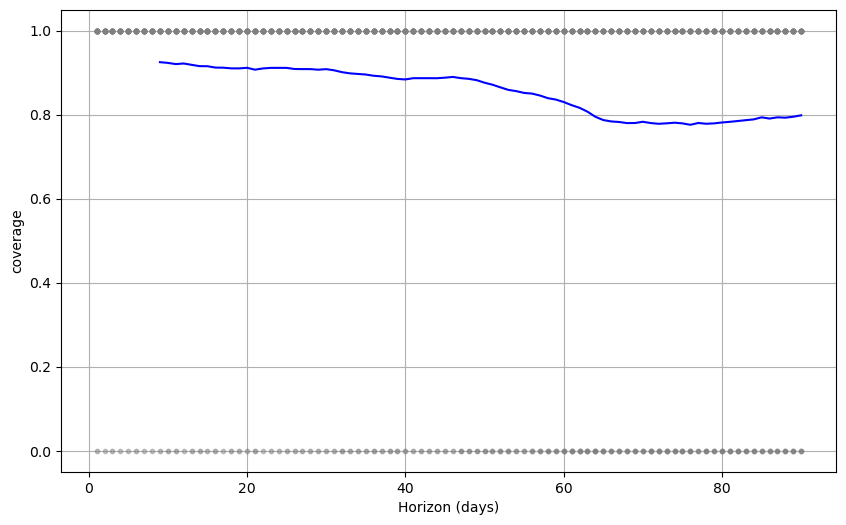

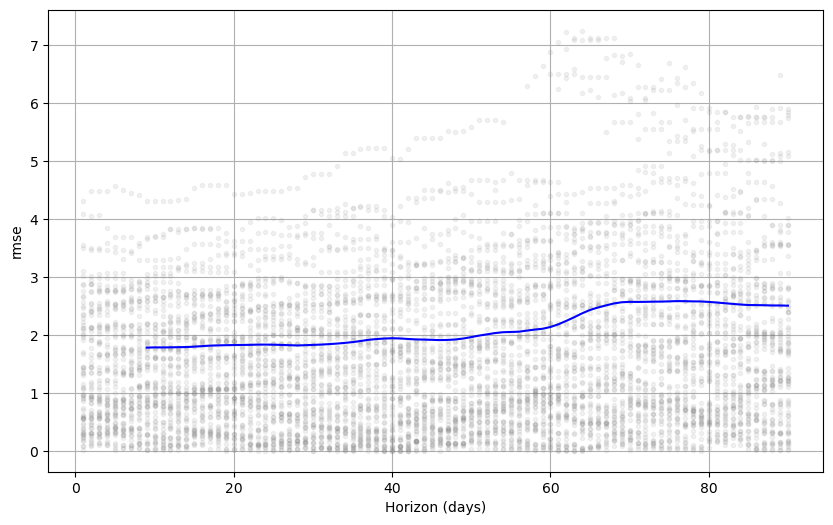

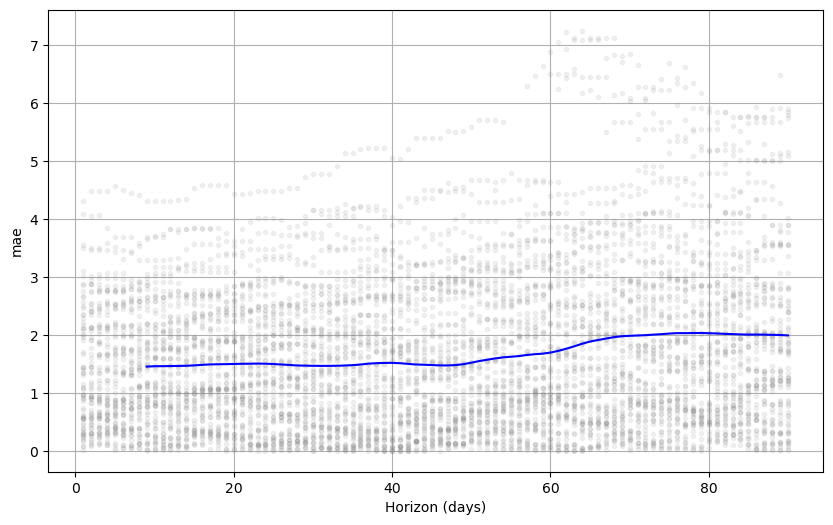

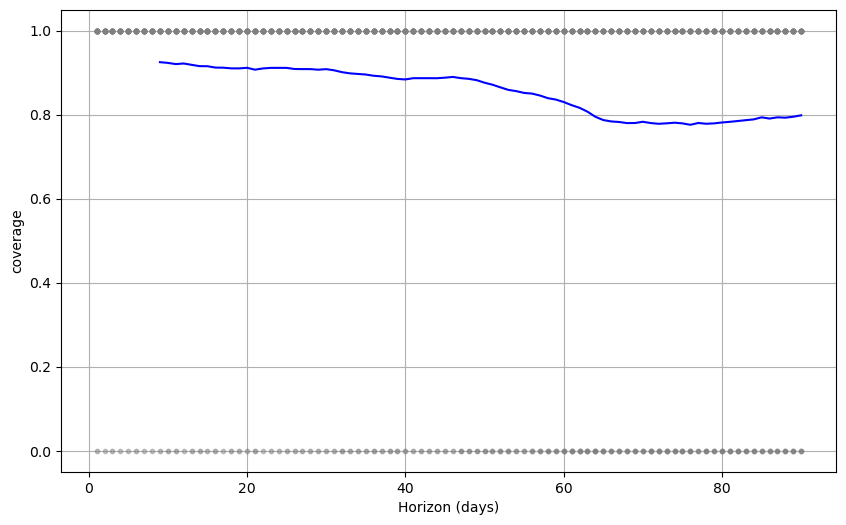

In [62]:
# Plot performance metrics
from prophet.plot import plot_cross_validation_metric

# Plot RMSE
plot_cross_validation_metric(cv_results, metric='rmse')

# Plot MAE
plot_cross_validation_metric(cv_results, metric='mae')

# Plot coverage
plot_cross_validation_metric(cv_results, metric='coverage')

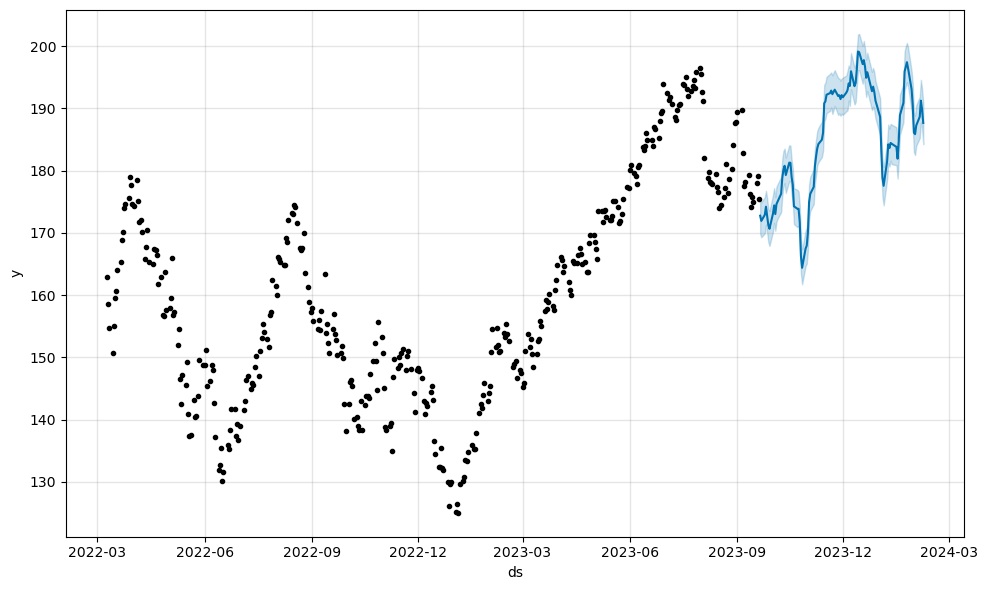

,ds,yhat,yhat_lower,yhat_upper,y
0,2023-09-21,172.763733,169.831808,175.620128,173.929993
1,2023-09-22,171.923768,169.303991,174.922141,174.789993
2,2023-09-25,172.913423,169.935831,175.723520,176.080002
3,2023-09-26,174.213074,171.319563,176.777468,171.960007
4,2023-09-27,172.698791,170.065863,175.516925,170.429993
...,...,...,...,...,...
92,2024-02-02,187.260733,183.994221,190.505007,185.850006
93,2024-02-05,188.663176,185.238670,191.868570,187.679993
94,2024-02-06,191.259709,187.738187,194.601658,189.300003
95,2024-02-07,189.843641,186.798544,193.146611,189.410004


In [63]:
# Make future dataframe for the testing period
future = test[['ds']].copy()
for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
    future[col] = test[col]

# Make predictions
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

# Merge the forecast with actual values from the test dataset
merged_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test[['ds', 'y']], on='ds')

# Display the merged DataFrame
display(merged_forecast)


In [64]:
# Evaluate model performance on the test set
y_true = test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 1.6561235684510764
Root Mean Squared Error: 1.986199334960813


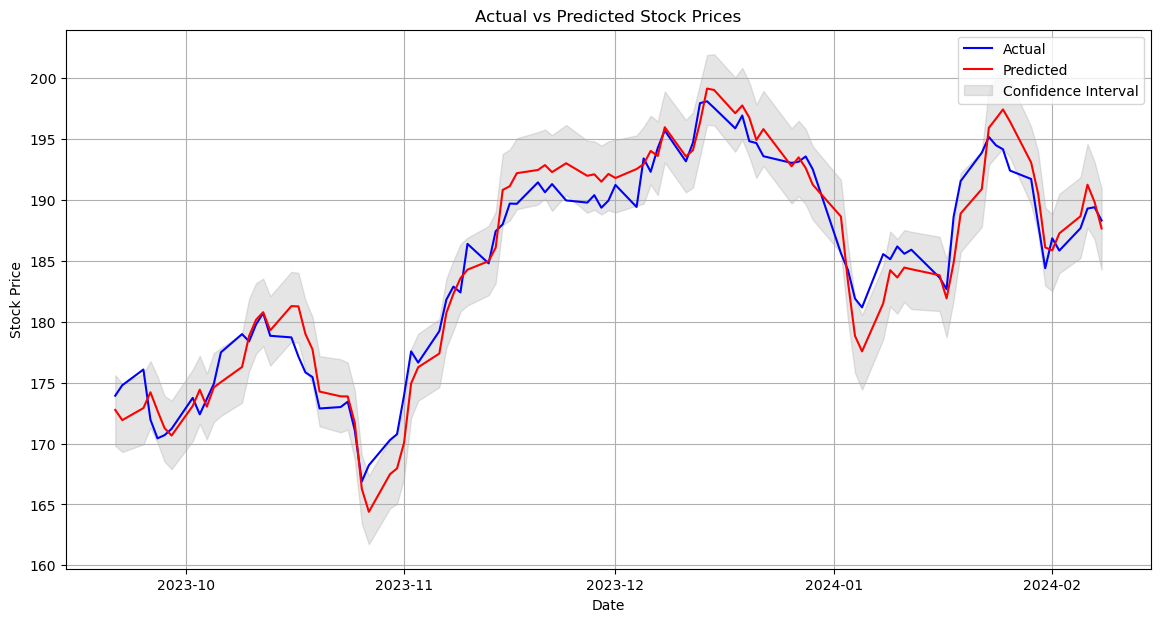

In [65]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(merged_forecast['ds'], merged_forecast['y'], label='Actual', color='blue')
plt.plot(merged_forecast['ds'], merged_forecast['yhat'], label='Predicted', color='red')
plt.fill_between(merged_forecast['ds'], merged_forecast['yhat_lower'], merged_forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

- **Analysis**: the predicted prices follow the actual prices reasonably well, with the confidence intervals covering most of the actual price points, indicating that the model is capturing the general trend with a fair degree of accuracy.

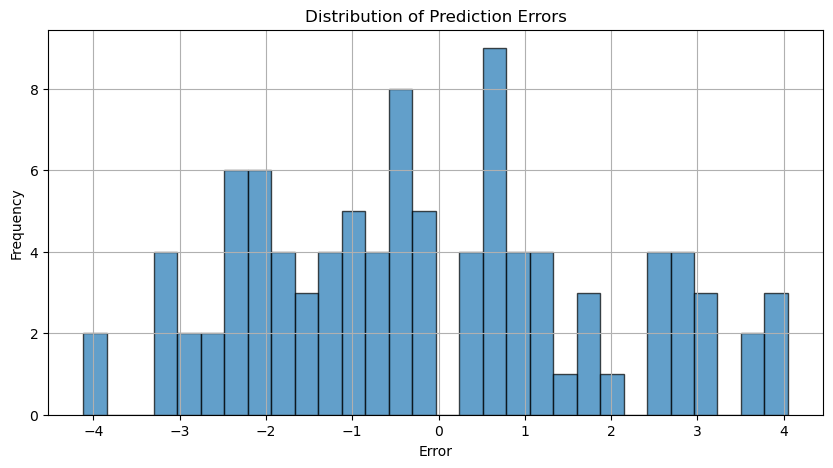

In [66]:
# Plot the distribution of prediction errors
errors = merged_forecast['y'] - merged_forecast['yhat']
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

- **Analysis**: the errors are somewhat symmetrically distributed around zero with a slight spread, indicating that the model generally performs well but has room for improvement in minimizing errors.

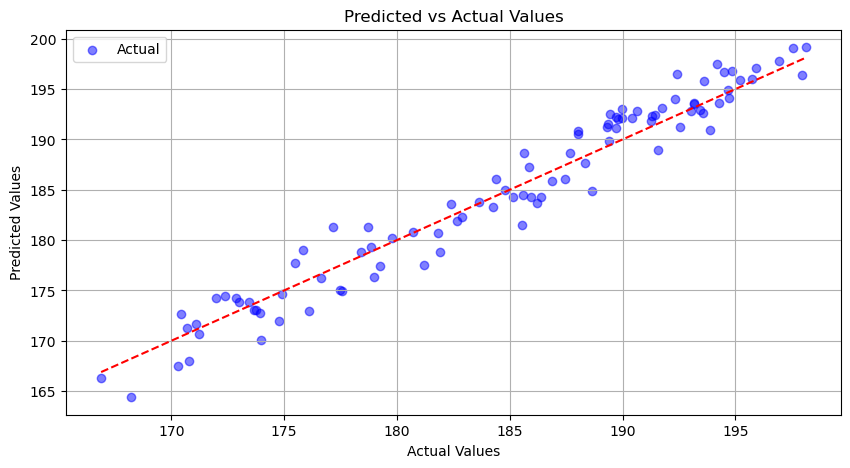

In [67]:
# Optional: Scatter plot to show prediction vs actual values
plt.figure(figsize=(10, 5))
plt.scatter(merged_forecast['y'], merged_forecast['yhat'], alpha=0.5, label='Actual', color='blue')
plt.plot([min(merged_forecast['y']), max(merged_forecast['y'])], [min(merged_forecast['y']), max(merged_forecast['y'])], '--', color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

- **Analysis**: most points are close to the red dashed line, suggesting that the predictions are generally accurate. However, there are some deviations, indicating occasional larger prediction errors.